# Imports and loading data in dataframe

In [1]:
import pandas as pd

#____loading data____
df = pd.read_csv('./data/clean_house.csv')
# df = pd.read_csv('./data/clean_app.csv')

#____creating pc_zone column____

# Convert 'postal_code' column to string type
df['postal_code'] = df['postal_code'].astype(str)

# Create a new column 'pc_zone' with the first two digits of the postal code
df['pc_zone'] = df['postal_code'].str[:2]

# EDA

### EDA summary

- we have a dataframe with 25 columns
- 8 columns have categorical data:
    - locality_name
    - main_city
    - province
    - property_type
    - type_of_sale
    - kitchen_type
    - state_of_building
    - property_subtype

- for houses we have 11394 rows

- These are the columns that have null values:

```
    number_of_rooms           8188
    terrace_area              7969
    swimming_pool             7550
    garden_area               7511
    furnished                 7404
    garden                    6775
    terrace                   4813
    kitchen_type              4046
    fully_equipped_kitchen    2422
    state_of_building         2338
    number_of_facades         1765
    latitude                  1468
    longitude                 1468
```

### REMARKS

- columns that should be converted to int (not sure if needed): `number of rooms`, `living area`, `fully equipped kitchen`, `furnished`, `terrace`, `garden`, `garden area`, `surface of good`, `number of facades`, `swimming pool`

# Handling outliers

In [2]:
# ____Outliers handling_____
import numpy as np 

Q1 = df["price"].quantile(0.25)
Q3 = df["price"].quantile(0.75)
IQR = Q3 - Q1

max_value = Q3 + (1.5 * IQR)
min_value = Q1 - (1.5 * IQR)

outliers_mask = (df["price"] < min_value) | (df["price"] > max_value)
df.loc[outliers_mask, "price"] = np.nan

df.dropna(subset=["price"], inplace=True)

# preprocessing

## converting dtypes



In [3]:
# ____converting dtypes____

import pandas as pd

# List of columns to convert to integer
columns_to_convert = ['postal_code', 'pc_zone']

# Convert specified columns to integer type
df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce').fillna(pd.NA)

df[columns_to_convert] = df[columns_to_convert].astype('Int64')

## Drop unnecessary columns

- `property_id` uniquely identifies a property (therefor it is not very useful for predicting a given outcome)
- same for `latitude`/`longitude` --> they were handy for the visuals, but have no added value for training a model
- `property_type` is not useful for predicting a given outcome as well as the split of houses and appartments was already done upfront in the cleaning resulting in different files
- `type_of_sale` is not useful for predicting a given outcome as most properties have a "BUY REGULAR" as value



In [4]:
# _____dropping unnecessary columns____
# for house and app
columns_to_drop = ['property_id', 'latitude', 'longitude', 'property_type', 'type_of_sale', 'fully_equipped_kitchen', 'postal_code']

df.drop(columns_to_drop, axis=1, inplace=True)

In [5]:
# for app only

# app_columns_to_drop = ['surface_of_good']

# df.drop(app_columns_to_drop, axis=1, inplace=True)

# Missing values handling

### Filling up swimming pool column with 0 when value is not filled in

In [6]:
# _____imputing missing values for swimmingpool____
from sklearn.impute import SimpleImputer
import numpy as np

constant_imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
df[['swimming_pool']] = constant_imputer.fit_transform(df[['swimming_pool']])


# One-hot encoding

- To handle columns:

- kitchen_type              4046 --> object      -----> One Hot Encoding
- state_of_building         2338 --> object      -----> One Hot Encoding
- property_subtype          0                    -----> One Hot Encoding    

    ```
    number_of_rooms           8188
    terrace_area              7969
    garden_area               7511
    furnished                 7404 --> 1/0 or NaN
    garden                    6775 --> 1/0 or NaN
    terrace                   4813 --> 1/0 or NaN
    fully_equipped_kitchen    2422 --> 1/0 or NaN
    number_of_facades         1765
    ```

`OneHotEncoder` from the `sklearn.preprocessing` module and `pd.get_dummies` from pandas are both used for one-hot encoding categorical variables.

The main differences are:

- `OneHotEncoder` is typically used in a machine learning pipeline within scikit-learn, while `pd.get_dummies` is a pandas function.
- `OneHotEncoder` requires you to first fit the encoder on the data and then transform it, while `pd.get_dummies` can be applied directly to the DataFrame.
- `OneHotEncoder` returns a sparse matrix by default, which can be memory efficient for large datasets, while `pd.get_dummies` returns a pandas DataFrame.
- `OneHotEncoder` can handle new categories not seen during fitting better than `pd.get_dummies`.
- Depending on your workflow and requirements, you can choose between the two options.

In [7]:
# _____one-hot encoding for kitchen_type____
df = pd.get_dummies(df, columns=["kitchen_type"], prefix="kitchen_type")

# _____one-hot encoding for state_of_building____
df = pd.get_dummies(df, columns=["state_of_building"], prefix="state_of_building")

# _____one-hot encoding for property_subtype____
df = pd.get_dummies(df, columns=["property_subtype"], prefix="property_subtype")

# _____one-hot encoding for province____
df = pd.get_dummies(df, columns=["province"], prefix="province")

# Creating a training and test set


#### Stratified sampling

- Can be used for when y is more classification values
    `X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)`

#### About datatypes

- X and y can be dataframes or of the type series (it all depends on the model)


In [8]:
# _____defining target and features____

columns_to_drop = ['price', 'locality_name', 'main_city']

# Drop the specified columns
X = df.drop(columns=columns_to_drop, axis=1)

y = df['price']

In [9]:
# _____creating training and testing sets____
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Imputation

- replacing missing values with statistical estimates of these missing data of these missing data or with arbitrary values
- it's common to use the mean or median to fill in missing values
- for categorical values we can use the mode (most frequent value)
- !!! must split our data first, to avoid data leakage !!!
- flag as missing or -1 or -999

https://medium.com/mastering-the-art-of-data-science-a-comprehensive/mastering-data-preprocessing-and-feature-engineering-for-machine-learning-missing-basic-data-a648d2cb1196#:~:text=Missing%20Data%20Imputation%3A%20Imputation%20is,models%20or%20obtain%20their%20predictions.

- These are the columns that have missing values in our case (for houses):

    ```
    number_of_rooms           8188
    terrace_area              7969
    swimming_pool             7550 --> 1/0 or NaN
    garden_area               7511
    furnished                 7404 --> 1/0 or NaN
    garden                    6775 --> 1/0 or NaN
    terrace                   4813 --> 1/0 or NaN
    kitchen_type              4046 --> object      -----> One Hot Encoding
    fully_equipped_kitchen    2422 --> 1/0 or NaN  -----> REMOVED (wrong logic)
    state_of_building         2338 --> object      -----> One Hot Encoding
    number_of_facades         1765
    property_subtype          0                    -----> One Hot Encoding
    ```




### Simple Imputation 

- filling with mean value: `missing = lambda x: x.fillna(x.mean())`
- or filling with median value: `missing = lambda x: x.fillna(x.median())`
- then using transform(): `df = df.transform(missing)`

- or do the same in another way:
    ``` python
    mean_value = df['column_name'].mean()
    df['column_name'] = df['column_name'].fillna(mean_value, inplace=True)
    ```
- SimpleImputer

    ```python
    from sklearn.impute import SimpleImputer
    mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    df[['column_name']] = mean_imputer.fit_transform(df[['column_name']])
    
    constant_imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-999)
    df[['column_name']] = constant_imputer.fit_transform(df[['column_name']])

    frequent_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    df[['column_name']] = frequent_imputer.fit_transform(df[['column_name']])

    constant_imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=MISS)
    df[['column_name']] = constant_imputer.fit_transform(df[['column_name']])
    ```	

### Advanced Imputation

- ! important to first normalize the data !

- K-nearest neighbors
- SMOTE (synthetic minority over-sampling technique)

    ``` Python
    from sklearn.impute import KNNImputer
    imputer = KNNImputer(n_neighbors=5, weights="uniform")
    df['column_name'] = imputer.fit_transform(df['column_name'])
    ```   

In [10]:
# _____imputing -1 for missing values for number_of_rooms, terrace_area, garden_area, furnished, garden, terrace, number_of_facades____

constant_imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)

colums_to_impute = ['number_of_rooms', 'terrace_area', 'garden_area', 'furnished', 'garden', 'terrace', 'number_of_facades']

X_train[colums_to_impute] = constant_imputer.fit_transform(X_train[colums_to_impute])
X_test[colums_to_impute] = constant_imputer.fit_transform(X_test[colums_to_impute])

# Train and test the model

### Linear Regression

In [11]:
from sklearn.linear_model import LinearRegression
import sklearn.metrics  
import math
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

linmodel = LinearRegression()

#____train the model____
linmodel.fit(X_train, y_train)

#____show the score____
print("linmodel training score: ", linmodel.score(X_train, y_train))

#____test the model____
y_lin_prediction = linmodel.predict(X_test)

#____show the score____
print("linmodel testscore: ", linmodel.score(X_test, y_test))

#____show the rmse____
mse = sklearn.metrics.mean_squared_error(y_test, y_lin_prediction)
rmse = math.sqrt(mse)
print("rmse: ",rmse)

#____show the r2_score____
print("train_r2_score: ", r2_score(y_train, linmodel.predict(X_train)))
print("test_r2_score: ", r2_score(y_test, linmodel.predict(X_test)))


print("cross val score: ", cross_val_score(linmodel, X_train, y_train).mean())


linmodel training score:  0.5970535937351242
linmodel testscore:  0.5884691982810448
rmse:  107215.3078703162
train_r2_score:  0.5970535937351242
test_r2_score:  0.5884691982810448
cross val score:  -0.8357214671759913


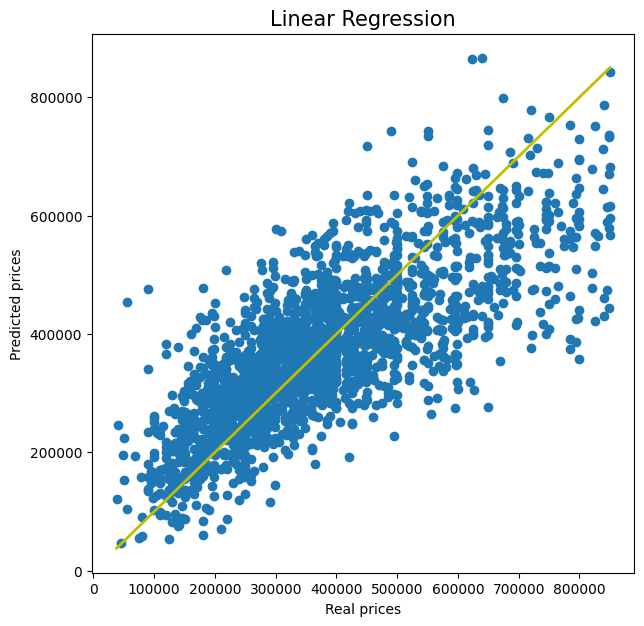

In [12]:
import matplotlib.pyplot as plt

fig = plt.subplots(figsize = (7, 7))

plt.scatter(y_test, y_lin_prediction)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'y', lw=2)
plt.xlabel("Real prices", size=10)
plt.ylabel("Predicted prices", size=10)
plt.title("Linear Regression", size=15)
plt.show()

# Random Forest Regression

!! runs 5m34s

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import sklearn.metrics  

param_grid = {
    'max_depth': [10, 15, 20, 25, 30, 40],
    'n_estimators': [100, 200]}
grid = GridSearchCV(RandomForestRegressor(), param_grid=param_grid)
grid.fit(X, y)
dept = grid.best_params_['max_depth']
estimators = grid.best_params_['n_estimators']

randomforest = RandomForestRegressor(n_estimators = estimators, max_depth = dept)

#____train the model____
randomforest.fit(X_train, y_train)

#____show the choosen max_depth____
print("randomforest choosen max_depth: ", dept)

#____show the choosen n_estimators____
print("randomforest choosen n_estimators: ", estimators)

#____show the score____
print("randomforest training score: ", randomforest.score(X_train, y_train))

#____test the model____
y_prediction = randomforest.predict(X_test)

#____show the score____
print("randomforest testscore: ", randomforest.score(X_test, y_test))

mse = sklearn.metrics.mean_squared_error(y_test, y_prediction)
rmse = math.sqrt(mse)
print("rmse: ",rmse)

print("cross val score: ", cross_val_score(randomforest, X_train, y_train).mean())

randomforest choosen max_depth:  25
randomforest choosen n_estimators:  200
randomforest training score:  0.9556387840770105
randomforest testscore:  0.683270752386701
rmse:  94058.85949553271
cross val score:  0.6713291665532634


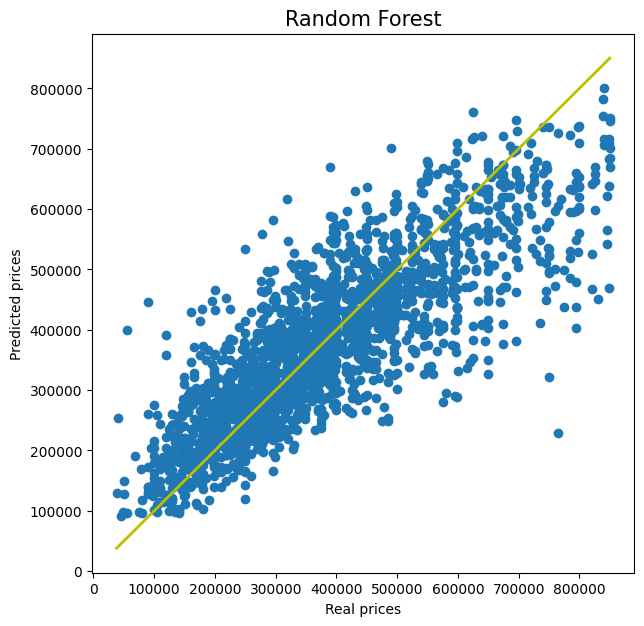

In [14]:
import matplotlib.pyplot as plt

fig = plt.subplots(figsize = (7, 7))

plt.scatter(y_test, y_prediction)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'y', lw=2)
plt.xlabel("Real prices", size=10)
plt.ylabel("Predicted prices", size=10)
plt.title("Random Forest", size=15)
plt.show()

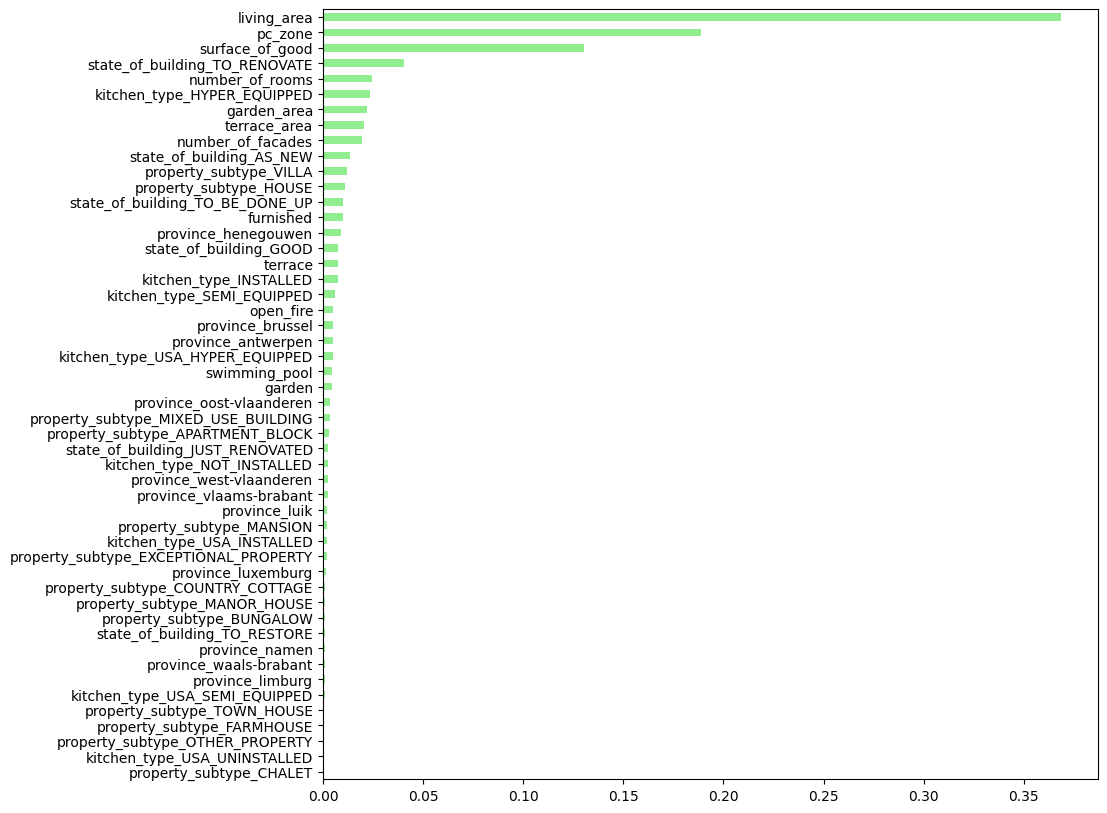

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

#feature importance
importance_rf = pd.Series(randomforest.feature_importances_, index=X.columns)

#sort importances
sorted_importance_rf = importance_rf.sort_values()

sorted_importance_rf.plot(kind='barh', color='lightgreen', figsize=(10, 10))
plt.show()

---